In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

In [2]:
train = pd.read_csv("./donejobs.cleaned.csv")

In [3]:
df_added_features =\
        train['jobName'].str.split(
            ":",
            expand=True)[[1, 2]].rename(columns={1: "jobName_1",
                                                 2: "jobName_2"})
train = pd.concat([train, df_added_features], axis=1)

In [4]:
del train['jobName']
train.head()

,memReq,numProcessors,avgMem,fromHost,maxMem,projectName,userGroup,userName,cpuTime,queue,command,jobName_1,jobName_2
0,2.7373,1,1.1858,sj-wkchow,1.8959,EDIRND,icd_1,wkchow,124.374,qosH,bash /vols/feflowrd_t1b_001/wkchow/sdisk400/qos/rundir/qos_run/TI_ddr_phys_28nm/TI_ddr_phys_28nm...,humtest,TI_ddr_phys_28nm
1,4.5615,1,1.7877,sj-wkchow,3.2384,EDIRND,icd_1,wkchow,222.200,qosH,bash /vols/feflowrd_t1b_001/wkchow/sdisk400/qos/rundir/qos_run/MMMC_brcm_AVD/MMMC_brcm_AVD_640_1...,humtest,MMMC_brcm_AVD
2,2.0156,1,0.7991,sj-wkchow,1.3901,EDIRND,icd_1,wkchow,77.424,qosH,bash /vols/feflowrd_t1b_001/wkchow/sdisk400/qos/rundir/qos_run/GF_trides_mac_20lpm/GF_trides_mac...,humtest,GF_trides_mac_20lpm
3,3.1758,1,1.3983,sj-wkchow,2.0619,EDIRND,icd_1,wkchow,133.506,qosH,bash /vols/feflowrd_t1b_001/wkchow/sdisk400/qos/rundir/qos_run/FSL_e6500_core_asvaaa_28nm/FSL_e6...,humtest,FSL_e6500_core_asvaaa_28nm
4,1.4219,1,0.6040,sj-wkchow,0.9200,EDIRND,icd_1,wkchow,97.877,qosH,bash /vols/feflowrd_t1b_001/wkchow/sdisk400/qos/rundir/qos_run/lym0_20nm/lym0_20nm_640_149434878...,humtest,lym0_20nm


In [5]:
for f in ['numProcessors','fromHost','projectName','userGroup','userName','queue','command','jobName_1','jobName_2']:
    train[f] = train[f].map(dict(zip(train[f].unique(), range(0, train[f].nunique()))))
train.head()

,memReq,numProcessors,avgMem,fromHost,maxMem,projectName,userGroup,userName,cpuTime,queue,command,jobName_1,jobName_2
0,2.7373,0,1.1858,0,1.8959,0,0.0,0,124.374,0,0,0.0,0.0
1,4.5615,0,1.7877,0,3.2384,0,0.0,0,222.200,0,1,0.0,1.0
2,2.0156,0,0.7991,0,1.3901,0,0.0,0,77.424,0,2,0.0,2.0
3,3.1758,0,1.3983,0,2.0619,0,0.0,0,133.506,0,3,0.0,3.0
4,1.4219,0,0.6040,0,0.9200,0,0.0,0,97.877,0,4,0.0,4.0


In [6]:
train = train.fillna(-1)
df_train, df_test = train_test_split(train, test_size=0.19999, train_size=0.8)
df_predict = train.drop(df_train.index.union(df_test.index)).reset_index()

In [7]:
y_train = df_train['maxMem'].values
del df_train['maxMem']
y1_train = df_test['maxMem'].values
del df_test['maxMem']

In [8]:
features = [f for f in train.columns if f not in ['maxMem']]

X_train = df_train[features].values
X_test = df_test[features].values
# one hot
enc = OneHotEncoder(categories='auto')
for f in features:
    enc.fit(train[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(df_train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(df_test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(320270, 960923)
(80064, 960923)


In [9]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(df_train))
predictions_lgb = np.zeros(len(df_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=20000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 90.5731	valid_1's l2: 108.875
[400]	training's l2: 59.7617	valid_1's l2: 80.7663
[600]	training's l2: 48.6514	valid_1's l2: 71.8332
[800]	training's l2: 42.112	valid_1's l2: 67.7951
[1000]	training's l2: 37.7108	valid_1's l2: 65.5566
[1200]	training's l2: 34.2177	valid_1's l2: 63.8095
[1400]	training's l2: 31.3826	valid_1's l2: 62.7786
[1600]	training's l2: 29.0969	valid_1's l2: 61.9042
[1800]	training's l2: 27.1513	valid_1's l2: 61.1767
[2000]	training's l2: 25.4596	valid_1's l2: 60.4826
[2200]	training's l2: 23.9366	valid_1's l2: 59.8877
[2400]	training's l2: 22.6359	valid_1's l2: 59.433
[2600]	training's l2: 21.4433	valid_1's l2: 59.0944
[2800]	training's l2: 20.4143	valid_1's l2: 58.7196
[3000]	training's l2: 19.4609	valid_1's l2: 58.425
[3200]	training's l2: 18.5676	valid_1's l2: 58.2192
[3400]	training's l2: 17.7592	valid_1's l2: 57.9803
[3600]	training's l2: 17.0221	valid_1's l2: 57.8502

[10600]	training's l2: 7.09173	valid_1's l2: 54.8538
[10800]	training's l2: 6.96654	valid_1's l2: 54.8364
[11000]	training's l2: 6.84834	valid_1's l2: 54.8034
[11200]	training's l2: 6.73362	valid_1's l2: 54.7862
[11400]	training's l2: 6.61852	valid_1's l2: 54.7556
[11600]	training's l2: 6.50529	valid_1's l2: 54.7328
[11800]	training's l2: 6.39775	valid_1's l2: 54.7218
[12000]	training's l2: 6.29253	valid_1's l2: 54.6896
[12200]	training's l2: 6.19423	valid_1's l2: 54.6718
[12400]	training's l2: 6.09518	valid_1's l2: 54.6558
[12600]	training's l2: 6.00094	valid_1's l2: 54.6557
[12800]	training's l2: 5.90921	valid_1's l2: 54.614
[13000]	training's l2: 5.8209	valid_1's l2: 54.5849
[13200]	training's l2: 5.73706	valid_1's l2: 54.5593
[13400]	training's l2: 5.65096	valid_1's l2: 54.5319
[13600]	training's l2: 5.57076	valid_1's l2: 54.5178
[13800]	training's l2: 5.4889	valid_1's l2: 54.5091
[14000]	training's l2: 5.4096	valid_1's l2: 54.496
[14200]	training's l2: 5.3355	valid_1's l2: 54.492


In [10]:
print("LGB score: {}".format((mean_squared_error(predictions_lgb, y1_train))))

LGB score: 60.3156016983


In [18]:
print(y1_train.max())

591.7914


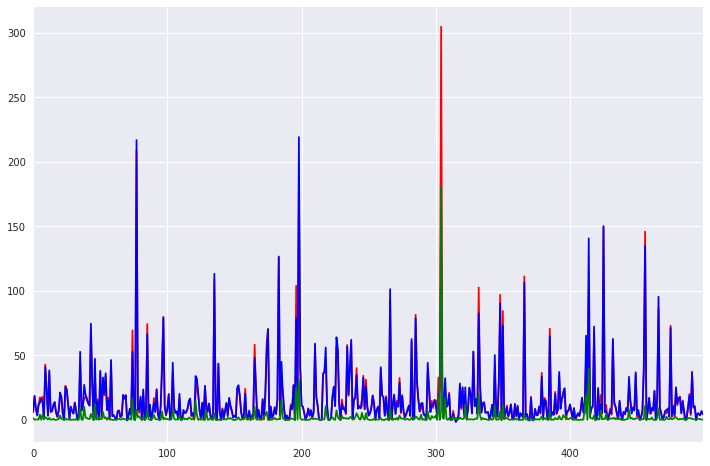

In [29]:
r = sns.tsplot(y1_train[500:1000], color="red")
b = sns.tsplot(predictions_lgb[500:1000], color="blue")
g = sns.tsplot(abs(y1_train - predictions_lgb)[500:1000], color="green")

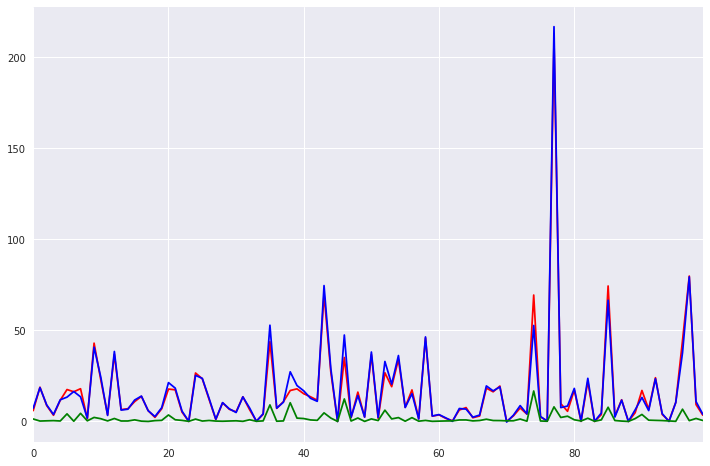

In [28]:
r = sns.tsplot(y1_train[500:600], color="red")
b = sns.tsplot(predictions_lgb[500:600], color="blue")
g = sns.tsplot(abs(y1_train - predictions_lgb)[500:600], color="green")